In [11]:
import gym
import numpy as np
import torch
import matplotlib
import matplotlib.pyplot as plt
import time
import tqdm as notebook_tqdm

from collections import deque
from ddqn_agent import Agent, FloatTensor

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
#if is_ipython:
    #from IPython import display

plt.ion()

use_cuda = torch.cuda.is_available()
#FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
device = torch.device("cuda" if use_cuda else "cpu")

BATCH_SIZE = 64  
TAU = 0.005 # 1e-3   # for soft update of target parameters
gamma = 0.99
LEARNING_RATE = 0.001
TARGET_UPDATE = 10

num_episodes = 2**9
print_every = 10
hidden_dim = 32 ## 16 
min_eps = 0.01
max_eps_episode = 150 ## 50

env = gym.make('CartPole-v1')
        
space_dim =  env.observation_space.shape[0] # n_spaces
action_dim = env.action_space.n # n_actions  
print('input_dim: ', space_dim, ', output_dim: ', action_dim, ', hidden_dim: ', hidden_dim)

threshold = env.spec.reward_threshold
print('threshold: ', threshold)

agent = Agent(space_dim, action_dim, hidden_dim)


input_dim:  4 , output_dim:  2 , hidden_dim:  32
threshold:  475.0


In [12]:
def epsilon_annealing(i_epsiode, max_episode, min_eps: float):
    """
    """
    t = i_epsiode // 50
    ret_eps = max(1/(t+1),min_eps)
    return ret_eps         

def save(directory, filename):
    torch.save(agent.q_local.state_dict(), '%s/%s_local.pth' % (directory, filename))
    torch.save(agent.q_target.state_dict(), '%s/%s_target.pth' % (directory, filename))

In [13]:
def run_episode(env, agent, eps):

    state = env.reset()
    done = False
    total_reward = 0
    

    while not done:

        action = agent.get_action(FloatTensor([state]), eps)
        
        next_state, reward, done, _ = env.step(action.item())

        total_reward += reward

        if done:
            reward = -1
                    
        # Store the transition in memory
        agent.replay_memory.push((FloatTensor([state]),action, FloatTensor([reward]), 
                 FloatTensor([next_state]), FloatTensor([done])))             

        if len(agent.replay_memory) > BATCH_SIZE:

            batch = agent.replay_memory.sample(BATCH_SIZE)
            
            agent.learn(batch, gamma)

        state = next_state


    return total_reward
#%%

In [14]:
def train():    

    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = []    
    
    time_start = time.time()

    for i_episode in range(num_episodes):
        eps = epsilon_annealing(i_episode, max_eps_episode, min_eps)
        score = run_episode(env, agent, eps)

        scores_deque.append(score)
        scores_array.append(score)
        
        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)

        dt = (int)(time.time() - time_start)
            
        if i_episode % print_every == 0 and i_episode > 0:
            print('Episode: {:5} Score: {:5}  Avg.Score: {:.2f}, eps-greedy: {:5.2f} Time: {:02}:{:02}:{:02}'.\
                    format(i_episode, score, avg_score, eps, dt//3600, dt%3600//60, dt%60))
            
        if len(scores_deque) == scores_deque.maxlen:
            ### 195.0: for cartpole-v0 and 475 for v1
            if np.mean(scores_deque) >= threshold: 
                print('\n Environment solved in {:d} episodes!\tAverage Score: {:.2f}'. \
                    format(i_episode, np.mean(scores_deque)))
                break

                        
        if i_episode % TARGET_UPDATE == 0:
            agent.q_target.load_state_dict(agent.q_local.state_dict()) 
    
    return scores_array, avg_scores_array

scores, avg_scores = train()

Episode:    10 Score:  14.0  Avg.Score: 16.55, eps-greedy:  1.00 Time: 00:00:00
Episode:    20 Score:  17.0  Avg.Score: 16.95, eps-greedy:  1.00 Time: 00:00:00
Episode:    30 Score:  13.0  Avg.Score: 17.94, eps-greedy:  1.00 Time: 00:00:00
Episode:    40 Score:  17.0  Avg.Score: 20.12, eps-greedy:  1.00 Time: 00:00:00
Episode:    50 Score:  16.0  Avg.Score: 19.75, eps-greedy:  0.50 Time: 00:00:00
Episode:    60 Score:  18.0  Avg.Score: 18.79, eps-greedy:  0.50 Time: 00:00:01
Episode:    70 Score:  11.0  Avg.Score: 17.87, eps-greedy:  0.50 Time: 00:00:01
Episode:    80 Score:  11.0  Avg.Score: 17.64, eps-greedy:  0.50 Time: 00:00:01
Episode:    90 Score:  13.0  Avg.Score: 17.13, eps-greedy:  0.50 Time: 00:00:01
Episode:   100 Score:  20.0  Avg.Score: 18.10, eps-greedy:  0.33 Time: 00:00:01
Episode:   110 Score: 144.0  Avg.Score: 21.43, eps-greedy:  0.33 Time: 00:00:02
Episode:   120 Score:  50.0  Avg.Score: 25.39, eps-greedy:  0.33 Time: 00:00:02
Episode:   130 Score:  66.0  Avg.Score: 

length of scores:  256 , len of avg_scores:  256


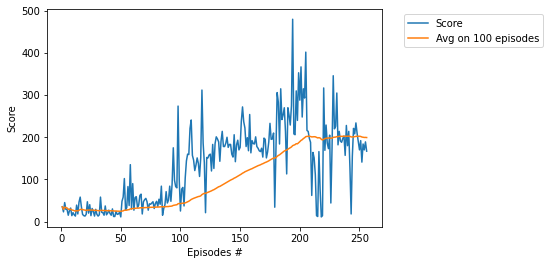

In [10]:
save('models/', 'ddq')
import matplotlib.pyplot as plt
%matplotlib inline

print('length of scores: ', len(scores), ', len of avg_scores: ', len(avg_scores))

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores, label="Score")
plt.plot(np.arange(1, len(avg_scores)+1), avg_scores, label="Avg on 100 episodes")
plt.legend(bbox_to_anchor=(1.05, 1)) 
plt.ylabel('Score')
plt.xlabel('Episodes #')
plt.show()